# First Stage Of Training:

In this stage we define a binary classification problem and try to solve it just with one of the input features. in this document you can see training prosedure on the **Ant Elevation BFTA** feature with a network with **DenseNet121** backbone.

## Preproccessing

Import Libraries

In [ ]:
## Importing Libs:
##
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from keras.models import Model
from keras.layers import Dense, Dropout, Input, MaxPooling2D  , Softmax, Flatten , Concatenate ,Conv2D
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers
from google.colab import drive
drive.mount('/content/drive')
import glob
from PIL import Image
from tensorflow import keras
import gc
#from keras.utils.layer_utils import count_params
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay
from keras.callbacks import ReduceLROnPlateau
path = '/content/drive/MyDrive/KCN/Semi_Final/'
##

Mounted at /content/drive


Load Data

In [ ]:
## Importing Data:
x2 = np.load(path+'x2.npy')   #Ant Elevation BFTA
Y= np.load(path+'Y.npy')
##

Center Crop:

In [ ]:
###
def center_crop(pic_array,pic_size):
  initial_size = pic_array.shape[1]
  new_pic_array =np.zeros((len(pic_array),pic_size,pic_size,3),dtype=np.uint8)
  for i in range(len(pic_array)):
    new_pic_array[i,:] = pic_array[i,(initial_size-pic_size)//2:initial_size-(initial_size-pic_size)//2,(initial_size-pic_size)//2:initial_size-(initial_size-pic_size)//2,:]

  del pic_array
  gc.collect()

  return new_pic_array
  del new_pic_array
  gc.collect()
  ###

In [ ]:
###
x_2=center_crop(x2,224)
###

Extract KCN and Normal Data:

In [ ]:
###

X_2 = np.zeros((len(Y),224,224,3),dtype=np.uint8)

j=0
for i in range(len(Y)):
  if(Y[i]==0):
    X_2[j,:]=x_2[i,:]
    j=j+1

  if(Y[i]==1):
    X_2[j,:]=x_2[i,:]
    j=j+1
###

One-Hot Out Put:

In [ ]:
###
y_c = np.zeros((len(Y),2))
for i in range (len(Y)) :
  if (Y[i]==0):
    y_c[i,0] = 1
  if (Y[i]==1):
    y_c[i,1]=1
###

In [ ]:
### generate id:
id = np.zeros(len(Y))
for i in range(len(Y)):
  id[i]=i
###

Train Test Split:

In [ ]:
X1_tr,X1_te, y_tr, y_te,id_tr,id_te = train_test_split(X_2,y_c,id,test_size=0.1, random_state=12)

In [ ]:
###
del x1,x2,x3,x4,X_1,X_2,X_3,X_4,X_5
gc.collect()
###

Class Distribution :

In [ ]:
###
def distribution(y_c):
  c1=0
  c2=0

  for i in range ((len(y_c))):
    if y_c[i,0]==1:
      c1=c1+1
    if y_c[i,1]==1:
      c2=c2+1

  return c1 ,c2

  ###

In [ ]:
###
print ('Original Data : '+ str(distribution(y_c)) +'\n')
print ('Train Data : '+ str(distribution(y_tr))+'\n')
print ('Test Data : '+ str(distribution(y_te))+ '\n')
###

Original Data : (1872, 1666)

Train Data : (1695, 1489)

Test Data : (177, 177)



## Model and Training

Define Model

In [ ]:
def Model_generator(input_shape):
  inputs_1 = layers.Input(shape =input_shape , name='Ant Elevation BFTA')
  x1 = inputs_1
  x1 = keras.applications.DenseNet121(input_tensor=x1,include_top=False,weights="imagenet",input_shape=input_shape)(x1)
  #x1 = branch_1.output
  x1 = MaxPooling2D((2,2),name = 'pooling_2')(x1)
  x1 = Conv2D(512 , 1, activation = 'relu')(x1)
  dataflow = Flatten(name='Flat')(x1)

  # Fully Connected Layer:

  f1 = Dense(128,name='Fully_Connected_1',activation='relu')(dataflow)
  f1 = Dropout(0.55,name='Dropout_1')(f1)
  f2 = Dense(64,name='Fully_Connected_2',activation='relu')(f1)
  f2 = Dropout(0.55,name='Dropout_2')(f2)
  f3 =  Dense(32,name='Fully_Connected_3',activation='relu')(f2)
  f3 = Dropout(0.55,name='Dropout_3')(f3)
  f4 =  Dense(2,name='Fully_Connected_4')(f3)

  output  = Softmax(axis=-1)(f4)
  return Model(inputs_1, output)


Build Model

In [ ]:
###
MODEL = Model_generator(input_shape = (224,224,3))
###

29084464/29084464 [==============================] - 0s 0us/step


Plot Model

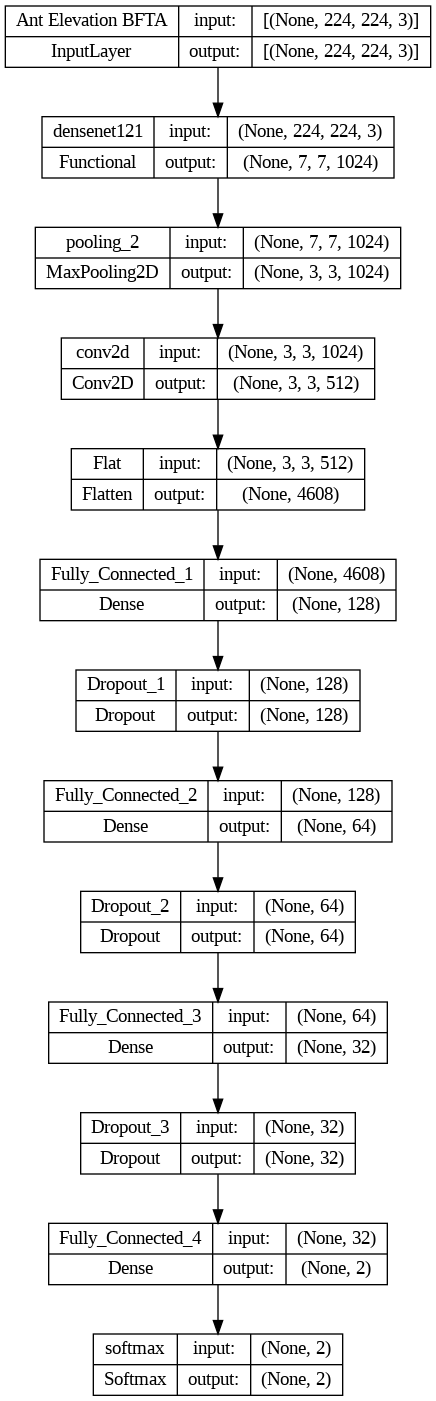

In [ ]:
keras.utils.plot_model(MODEL, to_file=path+"DEnseNet121_model.png", show_shapes=True)

Summary Of Model

In [ ]:
MODEL.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Ant Elevation BFTA (InputL  [(None, 224, 224, 3)]     0         
 ayer)                                                           
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 pooling_2 (MaxPooling2D)    (None, 3, 3, 1024)        0         
                                                                 
 conv2d (Conv2D)             (None, 3, 3, 512)         524800    
                                                                 
 Flat (Flatten)              (None, 4608)              0         
                                                                 
 Fully_Connected_1 (Dense)   (None, 128)               589952    
                                                             

Training Setup

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_gen = ImageDataGenerator(rotation_range=10,horizontal_flip=True, vertical_flip=True)

In [ ]:
###
adam = keras.optimizers.Adam(learning_rate=0.00005)
MODEL.compile(optimizer=adam,loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
Epoch =  100
reduceing_LR = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=25, min_lr=0.0000005)
best_save = ModelCheckpoint(path+'DenseNET121_(x2)_v3.h5',save_best_only=True,monitor='val_accuracy',mode='max')
#history=MODEL.fit(x=[X1_tr,X2_tr,X3_tr,X4_tr,X5_tr],y=y_tr, batch_size=16 , epochs=Epoch,validation_data=([X1_te,X2_te,X3_te,X4_te,X5_te],y_te) ,callbacks=[best_save,reduceing_LR])
history=MODEL.fit_generator(train_gen.flow(X1_tr, y_tr, batch_size=32), epochs=Epoch , steps_per_epoch=int(len(X1_tr)/32), validation_data=(X1_te, y_te),callbacks=[best_save,reduceing_LR])
###

<ipython-input-18-f046fb0f66fd>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=MODEL.fit_generator(train_gen.flow(X1_tr, y_tr, batch_size=32), epochs=Epoch , steps_per_epoch=int(len(X1_tr)/32), validation_data=(X1_te, y_te),callbacks=[best_save,reduceing_LR])


Epoch 1/100
99/99 [==============================] - ETA: 0s - loss: 0.9854 - accuracy: 0.5771

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


99/99 [==============================] - 166s 605ms/step - loss: 0.9854 - accuracy: 0.5771 - val_loss: 0.5766 - val_accuracy: 0.8249 - lr: 5.0000e-05
Epoch 2/100
99/99 [==============================] - 51s 510ms/step - loss: 0.6561 - accuracy: 0.6383 - val_loss: 0.4926 - val_accuracy: 0.7966 - lr: 5.0000e-05
Epoch 3/100
99/99 [==============================] - 52s 528ms/step - loss: 0.6139 - accuracy: 0.6653 - val_loss: 0.4580 - val_accuracy: 0.8531 - lr: 5.0000e-05
Epoch 4/100
99/99 [==============================] - 51s 515ms/step - loss: 0.5864 - accuracy: 0.6764 - val_loss: 0.4313 - val_accuracy: 0.8475 - lr: 5.0000e-05
Epoch 5/100
99/99 [==============================] - 54s 541ms/step - loss: 0.5731 - accuracy: 0.6789 - val_loss: 0.3517 - val_accuracy: 0.8559 - lr: 5.0000e-05
Epoch 6/100
99/99 [==============================] - 51s 513ms/step - loss: 0.5410 - accuracy: 0.7170 - val_loss: 0.3871 - val_accuracy: 0.8277 - lr: 5.0000e-05
Epoch 7/100
99/99 [==========================

## Training Diagrams of Loss And Accuracy

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


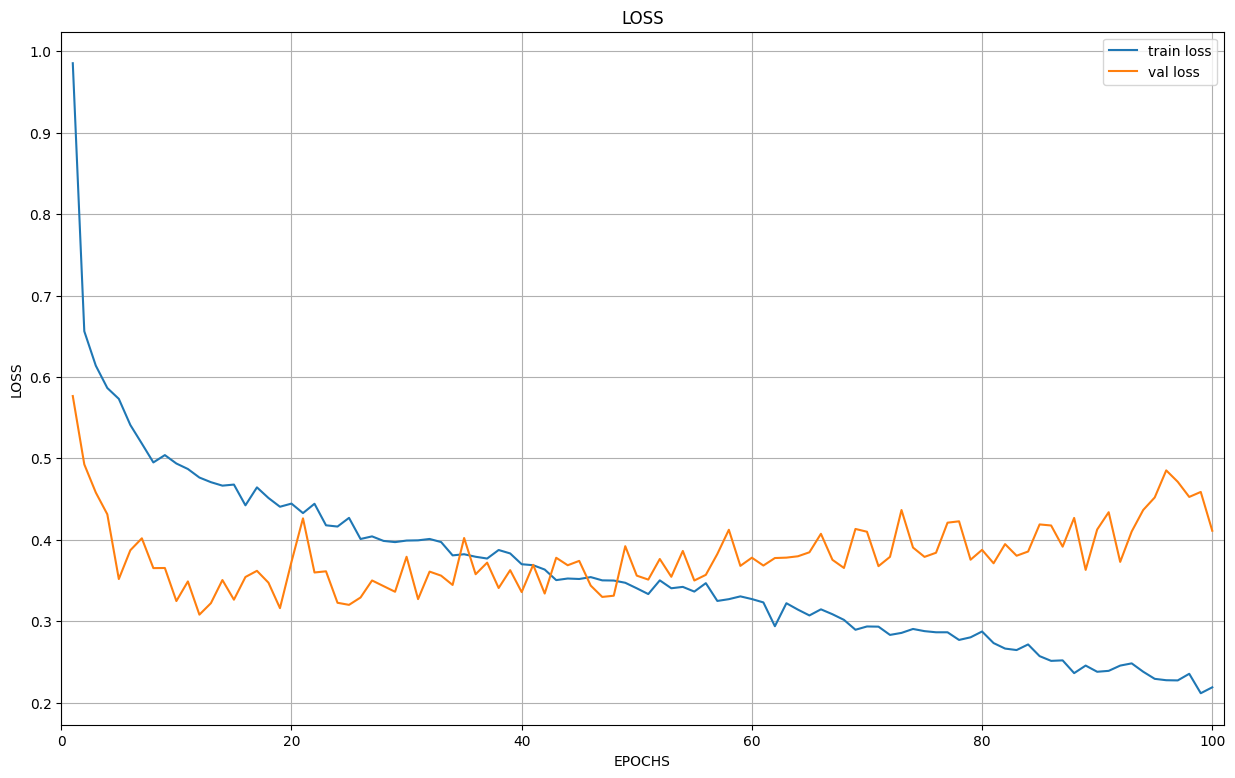

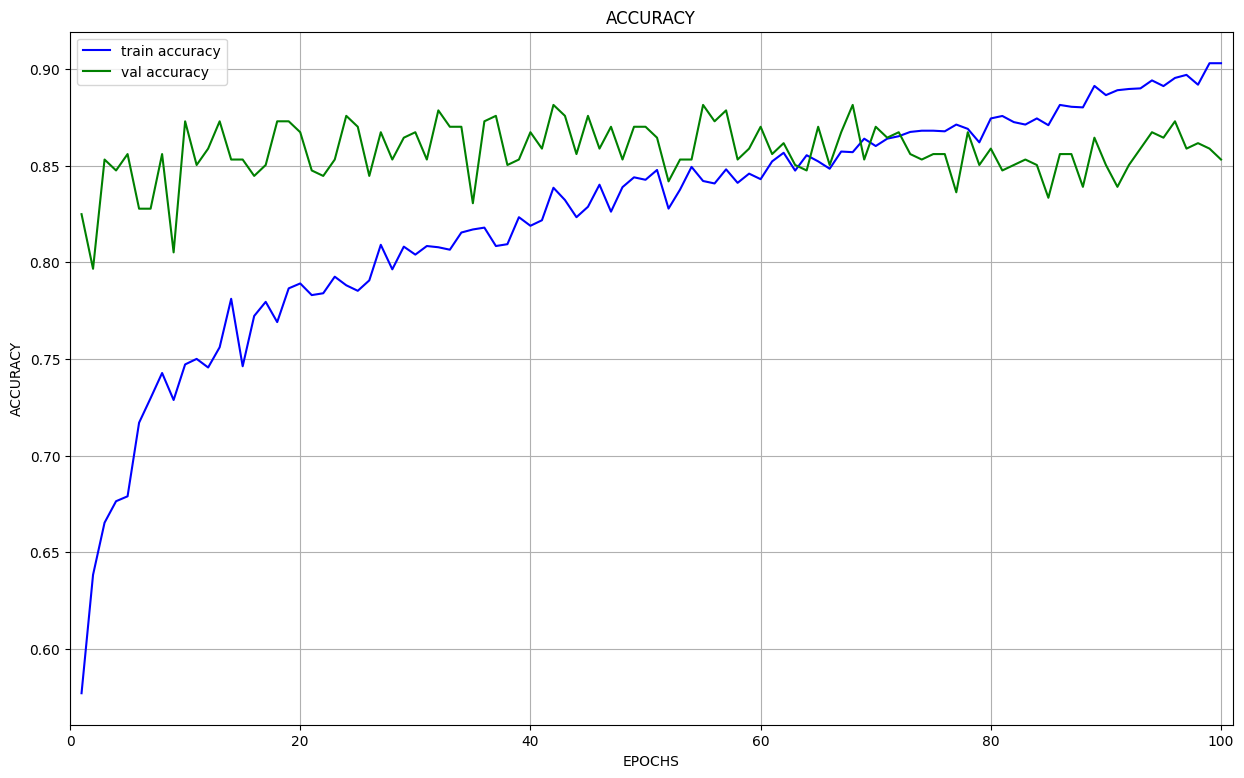

In [ ]:
###
drive.mount('/content/drive')
loss=history.history['loss']
val_loss=history.history['val_loss']
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
EPOCH= range(1,Epoch+1)

plt.gcf().set_size_inches(15,9,forward=True)
plt.plot(EPOCH,loss)
plt.plot(EPOCH,val_loss)
plt.title('LOSS')
plt.xlabel('EPOCHS')
plt.ylabel('LOSS')
plt.grid()
plt.xlim([0,Epoch+1])
plt.legend(['train loss','val loss'])

plt.savefig(path +'DenseNet121(x2)_Loss.jpg')
plt.show()
print(3*'\n')
print(3*'\n')
plt.gcf().set_size_inches(15,9,forward=True)
plt.plot(EPOCH,acc,color='b')
plt.plot(EPOCH,val_acc,color='g')
plt.title('ACCURACY')
plt.xlabel('EPOCHS')
plt.ylabel('ACCURACY')
plt.grid()
plt.xlim([0,Epoch+1])
plt.legend(['train accuracy','val accuracy'])

plt.savefig(path+'DenseNet121(x2)_ModelAcc.jpg')
plt.show()
###